Double Digit Classification using Deep Neural Network

Importing necessary packages

In [30]:
import matplotlib
import torch, torchvision
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import random 
import torch.nn.functional as F
from matplotlib import transforms as ts
from PIL import Image

from matplotlib.transforms import Affine2D
import mpl_toolkits.axisartist.floating_axes as floating_axes

from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Dataset
from PIL import Image

%matplotlib inline

# Setting the PseudoRandom Generator Seeds for better reproducibility

torch.manual_seed(99)
random.seed(99)
np.random.seed(99)

# this 'device' will be used for training our model
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [31]:
input_size  = 28*56   # images are 28x56 pixels
output_size = 100      # there are 100 classes
classNames = list(range(100))

Loading MNIST Dataset

In [32]:
mnist_full_train = torchvision.datasets.MNIST('./data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ]))

train_set, val_set = torch.utils.data.random_split(mnist_full_train, [50000, 10000])

train_loader = torch.utils.data.DataLoader(train_set, batch_size=10, shuffle=True)

val_loader = torch.utils.data.DataLoader(val_set, batch_size=10, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=10, shuffle=True)

Checking the dimensions

In [33]:
for batch_idx, (data, target) in enumerate(train_loader):
    data1 = torch.squeeze(data, 1)
    if batch_idx == 7:
        print(data.size(),target.size())
        break

torch.Size([10, 1, 28, 28]) torch.Size([10])


Function to create two digit data

In [34]:
def double(data_single, target_single):
        data_list = []
        target_list = []
        for i in range(10):
            for j in range(10):
                data_list.append((torch.cat((data_single[i], data_single[j]), 2)))
                target_list.append(torch.tensor(int(target_single[i])*10 + int(target_single[j])))
        
        return (data_list, target_list)

Displaying 1 batch of double digit images

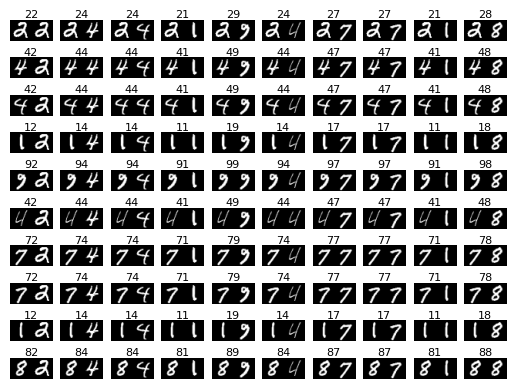

In [35]:
for ix, (img, lbl) in enumerate(train_loader):
    img_list, lbl_list = double(img, lbl)
    break
image = torch.stack(img_list)
label = torch.stack(lbl_list)

def visualize(image, label, num): 
    total = num
    if np.sqrt(num) != int(np.sqrt(num)):
        col = int(np.sqrt(num)) + 1 
    else:
        col = int(np.sqrt(num))
    rows = total // col
    if total % col != 0:
        rows += 1

    fig = plt.figure(1)
    for k in range(total):
        ax = fig.add_subplot(rows,col,k+1)
        ax.set_title(label[k].item(), size=8, pad=0)
        ax.axis('off')
        ax.imshow(image[k][0,:], cmap = 'gray')

    plt.show()

visualize(image, label, 100)

Creating the train, validation and test functions

In [36]:
def get_n_params(model):
    np=0
    for p in list(model.parameters()):
        np += p.nelement()
    return np


def train_val(epoch, model):
    N_tot = 0
    N_tot_val = 0
    train_loss = 0
    correct = 0
    val_loss = 0
    correct_val = 0
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data_new, target_new = double(data, target)
        
        data_tensor = torch.stack(data_new)
        target_tensor = torch.stack(target_new)
        data_tensor, target_tensor = data_tensor.to(device), target_tensor.to(device)
        
        optimizer.zero_grad()
        output = model(data_tensor)
        loss = F.cross_entropy(output, target_tensor)
        loss.backward()
        optimizer.step()
        N_tot += output.size(0)
        
        train_loss +=F.cross_entropy(output, target_tensor, reduction='sum').item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability                                                                 
        correct += pred.eq(target_tensor.data.view_as(pred)).cpu().sum().item()
   
    print('| Train_Loss: {:.4f}\tTrain_Accuracy: {:.4f}'.format(train_loss / N_tot, correct / N_tot))
    
    model.eval()
    for data, target in val_loader:
        # send to device
        data_new, target_new = double(data, target)
        
        data_tensor = torch.stack(data_new)
        target_tensor = torch.stack(target_new)
        data_tensor, target_tensor = data_tensor.to(device), target_tensor.to(device)
        
        output = model(data_tensor)
        val_loss += F.cross_entropy(output, target_tensor, reduction='sum').item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability                                                                 
        correct_val += pred.eq(target_tensor.data.view_as(pred)).cpu().sum().item()
        N_tot_val += output.size(0)
        
    print('| Validation_Loss: {:.4f}\tValidation_Accuracy: {:.4f}'.format(val_loss / N_tot_val, correct_val / N_tot_val))
    print('\n')
    
    return train_loss / N_tot, correct / N_tot, val_loss / N_tot_val, correct_val / N_tot_val
    
def test(model):
    test_loss = 0
    correct = 0
    N_tot = 0
    model.eval()
    for data, target in test_loader:
        # send to device
        data_new, target_new = double(data, target)
        
        data_tensor = torch.stack(data_new)
        target_tensor = torch.stack(target_new)
        data_tensor, target_tensor = data_tensor.to(device), target_tensor.to(device)
        
        output = model(data_tensor)
        test_loss += F.cross_entropy(output, target_tensor, reduction='sum').item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability                                                                 
        correct += pred.eq(target_tensor.data.view_as(pred)).cpu().sum().item()
        N_tot += output.size(0)
                
    print('| Test_Loss: {:.4f}\tTest_Accuracy: {:.4f}'.format(test_loss / N_tot, correct / N_tot))
    print('\n')
    
    return test_loss / N_tot, correct / N_tot

Fully Connected Network

In [37]:
class FC2Layer(nn.Module):
    def __init__(self, input_size, output_size):
        super(FC2Layer, self).__init__()
        self.input_size = input_size
        self.network = nn.Sequential(
            nn.Linear(input_size, 500), 
            nn.ReLU(), 
            nn.Linear(500,250),
            nn.ReLU(),
            nn.Linear(250,200), 
            nn.ReLU(), 
            nn.Linear(200, output_size), 
            nn.LogSoftmax(dim=1)
        )

    def forward(self, x):
        x = torch.stack(tuple(x))
        x = x.view(-1, self.input_size)
        return self.network(x)

Train the Network

In [38]:
print("Training on: ", device)
model_fnn = FC2Layer(input_size, output_size)
model_fnn.to(device)
optimizer = optim.SGD(model_fnn.parameters(), lr=0.001, momentum=0.9)
print('Number of parameters: {}'.format(get_n_params(model_fnn)))

epoch_length = 20
epoch = list(range(epoch_length))
train_loss = list(range(epoch_length))
train_accuracy = list(range(epoch_length))
val_loss = list(range(epoch_length))
val_accuracy = list(range(epoch_length))

for i in range(epoch_length):
    print('| Epoch No.: {:.0f}'.format(i + 1))
    print('\n')
    
    train_loss[i], train_accuracy[i], val_loss[i], val_accuracy[i] = train_val(i, model_fnn)
    


Training on:  cuda:0
Number of parameters: 980050
| Epoch No.: 1


| Train_Loss: 1.8397	Train_Accuracy: 0.5547
| Validation_Loss: 0.7479	Validation_Accuracy: 0.7831


| Epoch No.: 2


| Train_Loss: 0.5927	Train_Accuracy: 0.8369
| Validation_Loss: 0.4663	Validation_Accuracy: 0.8658


| Epoch No.: 3


| Train_Loss: 0.3965	Train_Accuracy: 0.8881
| Validation_Loss: 0.3533	Validation_Accuracy: 0.8965


| Epoch No.: 4


| Train_Loss: 0.2865	Train_Accuracy: 0.9172
| Validation_Loss: 0.2981	Validation_Accuracy: 0.9126


| Epoch No.: 5


| Train_Loss: 0.2226	Train_Accuracy: 0.9349
| Validation_Loss: 0.2441	Validation_Accuracy: 0.9278


| Epoch No.: 6


| Train_Loss: 0.1816	Train_Accuracy: 0.9462
| Validation_Loss: 0.2246	Validation_Accuracy: 0.9340


| Epoch No.: 7


| Train_Loss: 0.1479	Train_Accuracy: 0.9561
| Validation_Loss: 0.2104	Validation_Accuracy: 0.9398


| Epoch No.: 8


| Train_Loss: 0.1256	Train_Accuracy: 0.9620
| Validation_Loss: 0.2241	Validation_Accuracy: 0.9361


| Epoch No.: 9

Analysing the performance of the model on the test dataset

In [39]:
test_loss, test_accuracy = test(model_fnn)

| Test_Loss: 0.1812	Test_Accuracy: 0.9565




Therefore, we get an accuracy of 95.65% on the test data after training the model for 20 epochs.

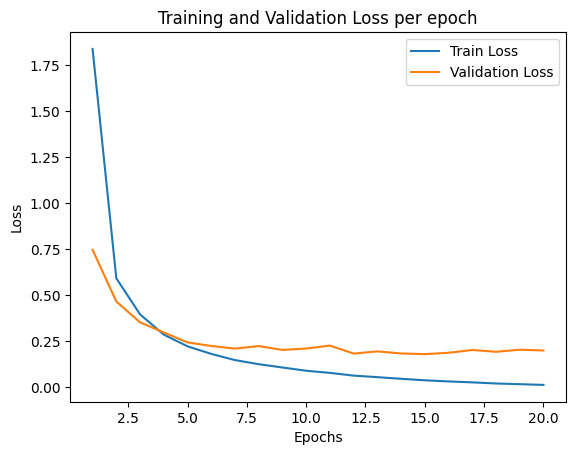

In [40]:
epoch = list(range(1,epoch_length + 1))
plt.plot(epoch, train_loss[:epoch_length], label='Train Loss')
plt.plot(epoch, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss per epoch')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()

Some predictions of the test network

In [41]:
def imshow(img, plot):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()   # convert from tensor
    plot.imshow(np.transpose(npimg, (1, 2, 0))) 

In [42]:
def visualize_pred(img, pred_prob, real_label):
    ''' Function for viewing an image and it's predicted classes.
    '''
    #pred_prob = pred_prob.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    #ax1.imshow(img.numpy().squeeze())
    imshow(img, ax1)
    ax1.axis('off')
    pred_label = np.argmax(pred_prob)
    ax1.set_title([classNames[real_label], classNames[pred_label]])
    
    #base = pyplot.gca().transData
    #rot = ts.Affine2D().rotate_deg(90)
    ax2.barh(np.arange(100), pred_prob)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(100))
    ax2.set_yticklabels(np.arange(100))
    ax2.set_title('Prediction Probability')
    ax2.set_xlim(0, 1.1)
    
    plt.tight_layout()
    

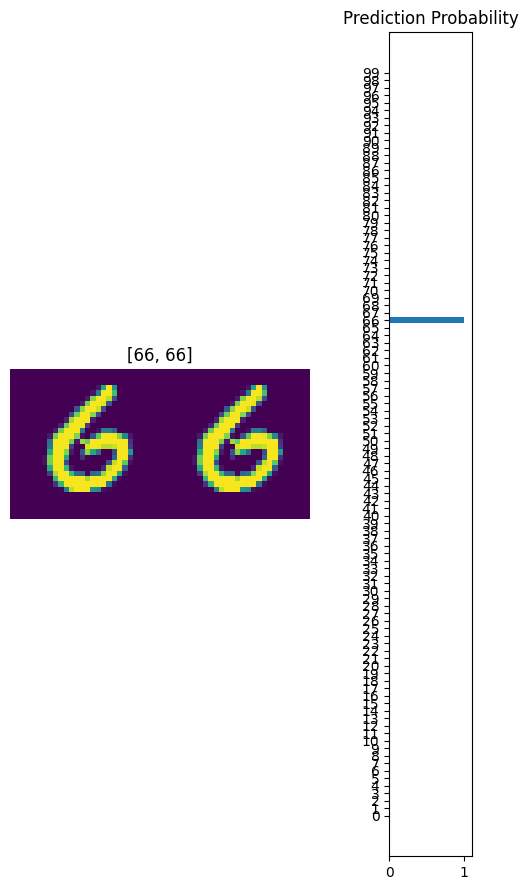

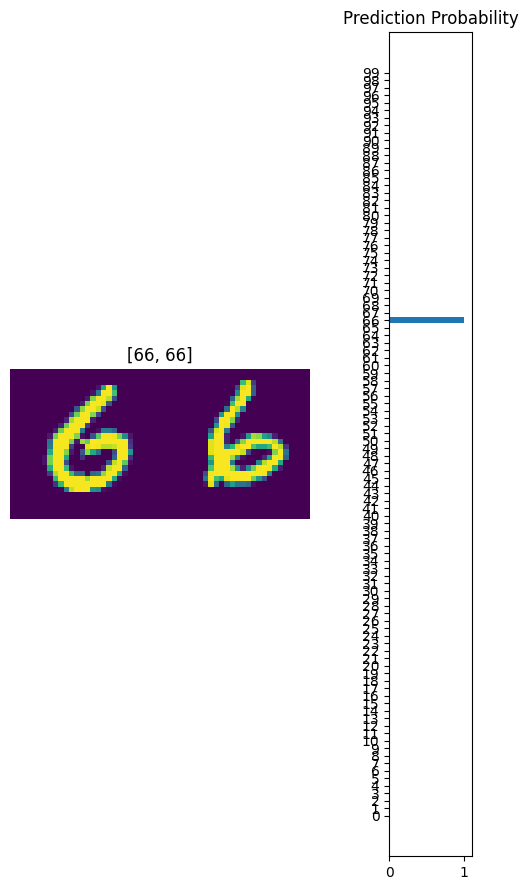

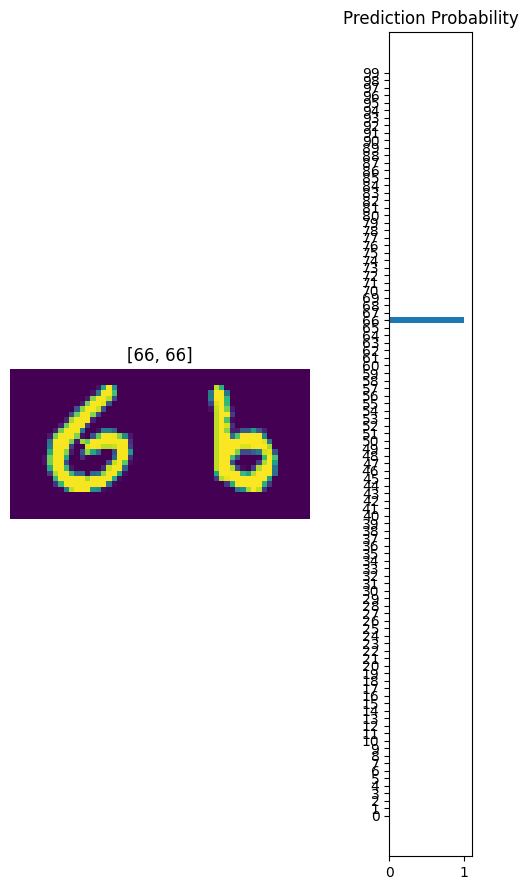

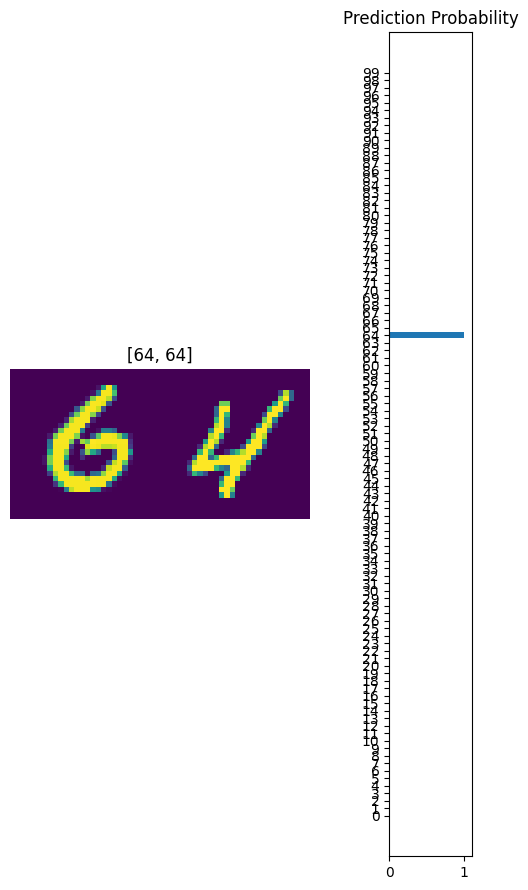

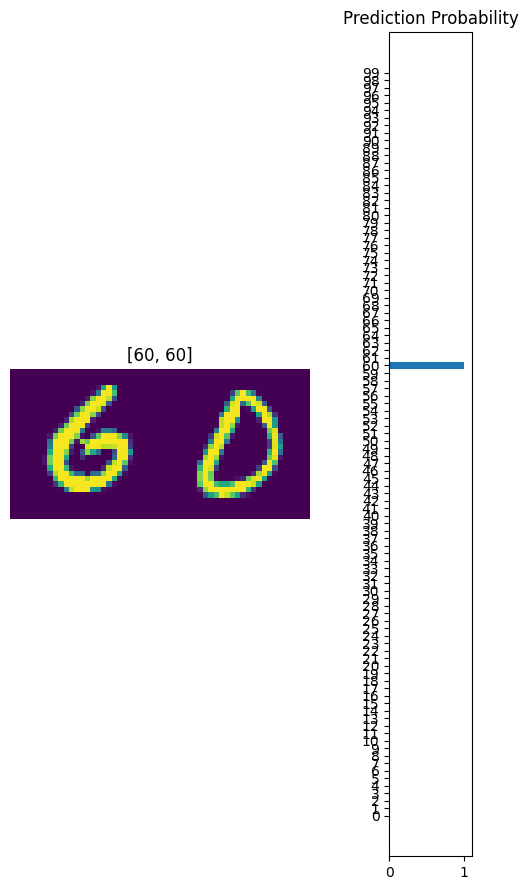

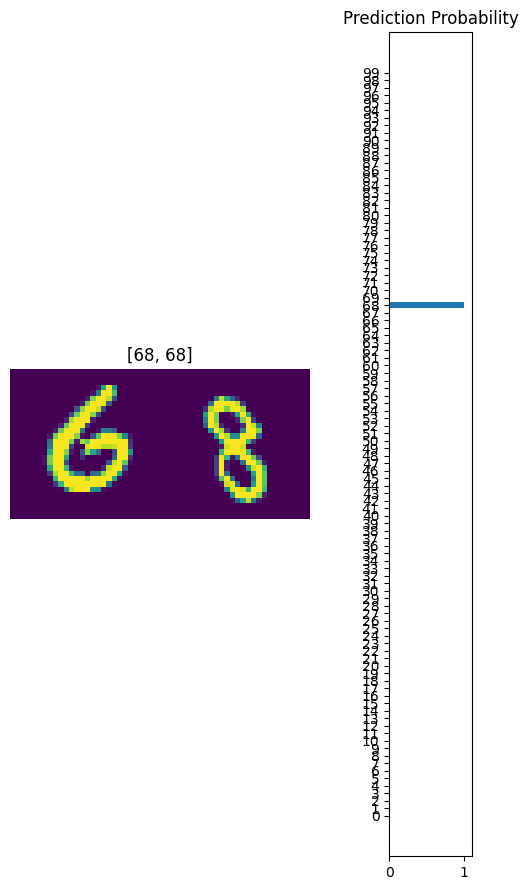

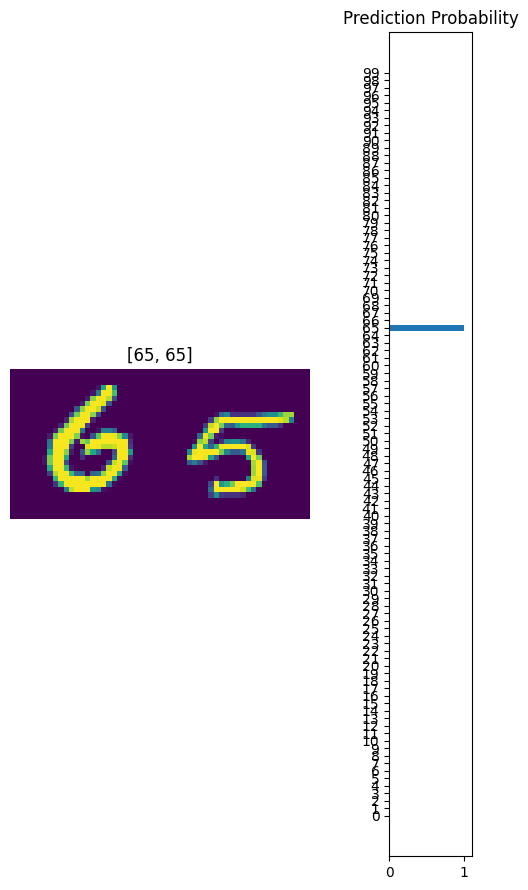

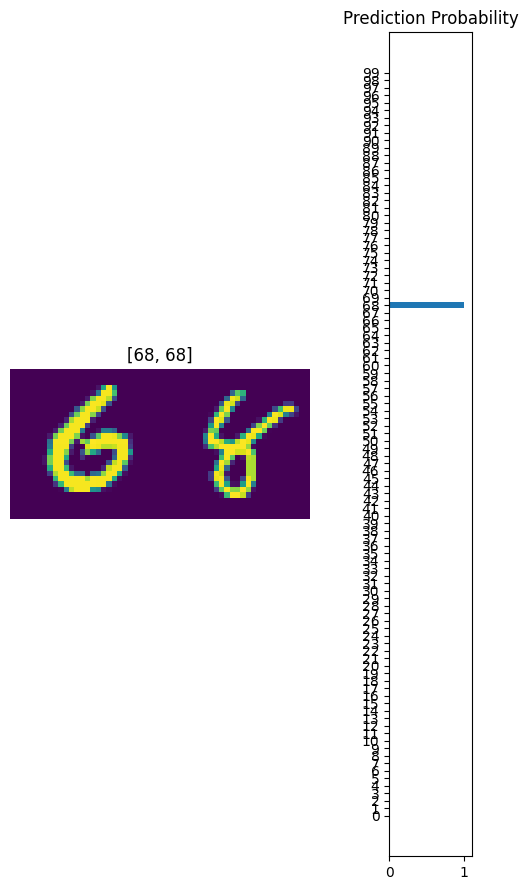

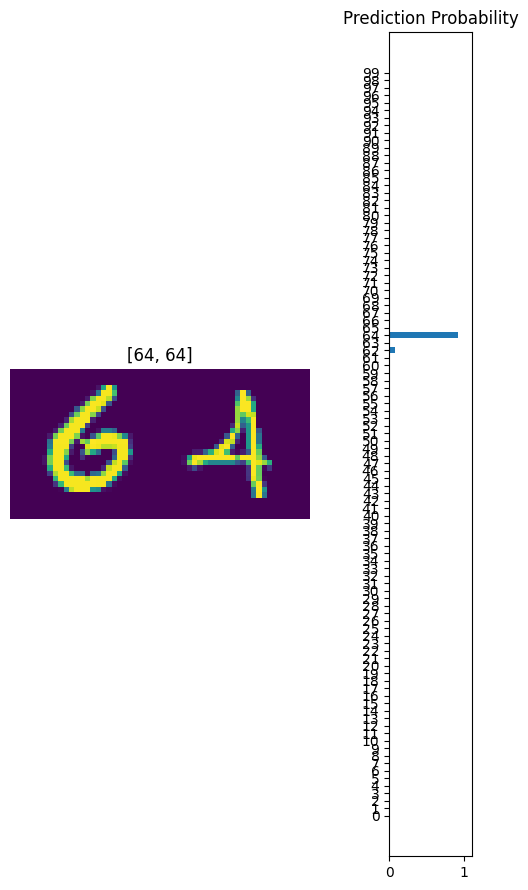

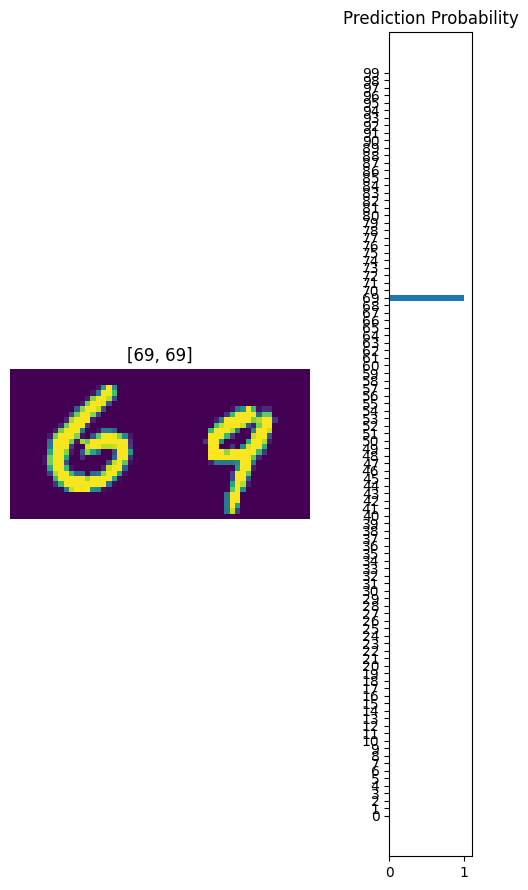

In [43]:
model_fnn.to('cpu') 

# fetch a batch of test images
image_batch, label_batch = next(iter(test_loader))
img_new, lbl_new = double(image_batch, label_batch)
        
img_tensor = torch.stack(img_new)
lbl_tensor = torch.stack(lbl_new)

# Turn off gradients to speed up this part
with torch.no_grad():
    log_pred_prob_batch = model_fnn(img_tensor)
for i in range(10):
    img = img_tensor[i]
    real_label = lbl_tensor[i].item()
    log_pred_prob = log_pred_prob_batch[i]
    # Output of the network are log-probabilities, need to take exponential for probabilities
    pred_prob = torch.exp(log_pred_prob).data.numpy().squeeze()
    visualize_pred(img, pred_prob, real_label)

Since, Fully Connected Networks do not use visual information we see what happens when we scramble the inputs

Visualizing how the scrambled data looks like

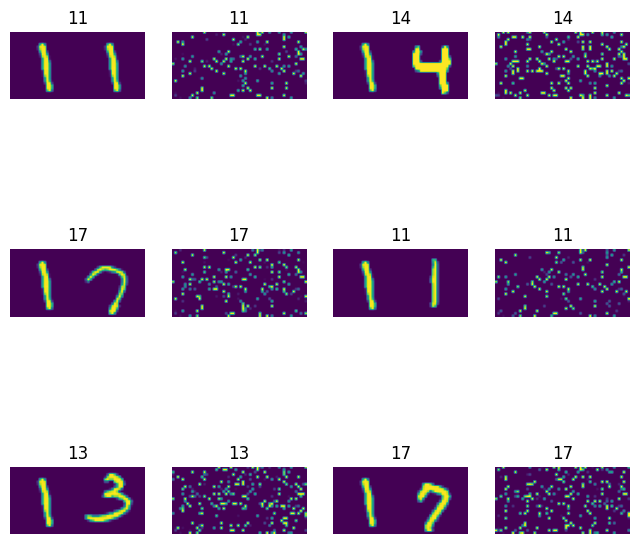

In [44]:
fixed_perm = torch.randperm(1568) # Fix a permutation of the image pixels; We apply the same permutation to all images

# show some training images
plt.figure(figsize=(8, 8))

# fetch a batch of train images; RANDOM
image_batch, label_batch = next(iter(train_loader))

img_list, lbl_list = double(image_batch, label_batch)

image = torch.stack(img_list)
label = torch.stack(lbl_list)

for i in range(6):
    img = image[i]
    image_perm = img.view(-1, 28*56).clone()
    image_perm = image_perm[:, fixed_perm]
    image_perm = image_perm.view(-1, 1, 28, 56)
    
    lbl = label[i].item()
    plt.subplot(3,4 , 2*i + 1)
    
    plt.imshow(img.squeeze().numpy())
    plt.axis('off')
    plt.title(lbl)
    plt.subplot(3, 4, 2*i+2)
    plt.imshow(image_perm.squeeze().numpy())
    plt.axis('off')
    plt.title(lbl)

Creating the train, validation and test functions using the scrambled data

In [45]:
def scramble_train(epoch, model, perm=fixed_perm):
    N_tot = 0
    N_tot_val = 0
    train_loss = 0
    correct = 0
    val_loss = 0
    correct_val = 0
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        #send to device
        data_new, target_new = double(data, target)
        
        data_tensor = torch.stack(data_new)
        target_tensor = torch.stack(target_new)
        data_tensor, target_tensor = data_tensor.to(device), target_tensor.to(device)
        
        # permute pixels
        data_tensor = data_tensor.view(-1, 28*56)
        data_tensor = data_tensor[:, perm]
        data_tensor = data_tensor.view(-1, 1, 28, 56)

        optimizer.zero_grad()
        output = model(data_tensor)
        loss = F.cross_entropy(output, target_tensor)
        loss.backward()
        optimizer.step()
        N_tot += output.size(0)
        
        train_loss += F.cross_entropy(output, target_tensor, reduction='sum').item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability                                                                 
        correct += pred.eq(target_tensor.data.view_as(pred)).cpu().sum().item()
   
    print('| Train_Loss: {:.4f}\tTrain_Accuracy: {:.4f}'.format(train_loss / N_tot, correct / N_tot))
    
    model.eval()
    for data, target in val_loader:
        # send to device
        data_new, target_new = double(data, target)
        
        data_tensor = torch.stack(data_new)
        target_tensor = torch.stack(target_new)
        data_tensor, target_tensor = data_tensor.to(device), target_tensor.to(device)
        
        # permute pixels
        data_tensor = data_tensor.view(-1, 28*56)
        data_tensor = data_tensor[:, perm]
        data_tensor = data_tensor.view(-1, 1, 28, 56)
        
        output = model(data_tensor)
        val_loss += F.cross_entropy(output, target_tensor, reduction='sum').item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability                                                                 
        correct_val += pred.eq(target_tensor.data.view_as(pred)).cpu().sum().item()
        N_tot_val += output.size(0)
        
    print('| Validation_Loss: {:.4f}\tValidation_Accuracy: {:.4f}'.format(val_loss / N_tot_val, correct_val / N_tot_val))
    print('\n')
    
    return train_loss / N_tot, correct / N_tot, val_loss / N_tot_val, correct_val / N_tot_val
    
def scramble_test(model, perm=fixed_perm):
    test_loss = 0
    correct = 0
    N_tot = 0
    model.eval()
    
    for data, target in test_loader:
        # send to device
        data_new, target_new = double(data, target)
        
        data_tensor = torch.stack(data_new)
        target_tensor = torch.stack(target_new)
        data_tensor, target_tensor = data_tensor.to(device), target_tensor.to(device)
        
        # permute pixels
        data_tensor = data_tensor.view(-1, 28*56)
        data_tensor = data_tensor[:, perm]
        data_tensor = data_tensor.view(-1, 1, 28, 56)
        
        output = model(data_tensor)
        test_loss += F.cross_entropy(output, target_tensor, reduction='sum').item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability                                                                 
        correct += pred.eq(target_tensor.data.view_as(pred)).cpu().sum().item()
        N_tot += output.size(0)
                
    print('| Test_Loss: {:.4f}\tTest_Accuracy: {:.4f}'.format(test_loss / N_tot, correct / N_tot))
    print('\n')
    
    return test_loss / N_tot, correct / N_tot

We now train the network on the same fully connected network architecture we defined before

In [46]:
print("Training on ", device)
model_fnn_2 = FC2Layer(input_size, output_size)
model_fnn_2.to(device)
optimizer = optim.SGD(model_fnn_2.parameters(), lr=0.001, momentum=0.9)
print('Number of parameters: {}'.format(get_n_params(model_fnn_2)))

epoch_length = 20
epoch = list(range(epoch_length))
train_loss = list(range(epoch_length))
train_accuracy = list(range(epoch_length))
val_loss = list(range(epoch_length))
val_accuracy = list(range(epoch_length))

for i in range(epoch_length):
    #epoch[i] = i + 1
    print('| Epoch No.: {:.0f}'.format(i + 1))
    print('\n')
    
    train_loss[i], train_accuracy[i], val_loss[i], val_accuracy[i] = scramble_train(i, model_fnn_2, fixed_perm)

Training on  cuda:0
Number of parameters: 980050
| Epoch No.: 1


| Train_Loss: 1.7522	Train_Accuracy: 0.5735
| Validation_Loss: 0.7220	Validation_Accuracy: 0.7999


| Epoch No.: 2


| Train_Loss: 0.5877	Train_Accuracy: 0.8364
| Validation_Loss: 0.5024	Validation_Accuracy: 0.8560


| Epoch No.: 3


| Train_Loss: 0.3877	Train_Accuracy: 0.8904
| Validation_Loss: 0.3537	Validation_Accuracy: 0.8990


| Epoch No.: 4


| Train_Loss: 0.2777	Train_Accuracy: 0.9203
| Validation_Loss: 0.2875	Validation_Accuracy: 0.9165


| Epoch No.: 5


| Train_Loss: 0.2173	Train_Accuracy: 0.9364
| Validation_Loss: 0.2398	Validation_Accuracy: 0.9313


| Epoch No.: 6


| Train_Loss: 0.1758	Train_Accuracy: 0.9486
| Validation_Loss: 0.2329	Validation_Accuracy: 0.9307


| Epoch No.: 7


| Train_Loss: 0.1450	Train_Accuracy: 0.9568
| Validation_Loss: 0.2113	Validation_Accuracy: 0.9381


| Epoch No.: 8


| Train_Loss: 0.1215	Train_Accuracy: 0.9629
| Validation_Loss: 0.2034	Validation_Accuracy: 0.9407


| Epoch No.: 9


Analysing the performance of the model on the test dataset

In [47]:
test_loss, test_accuracy = scramble_test(model_fnn_2, fixed_perm)

| Test_Loss: 0.1727	Test_Accuracy: 0.9606




Therefore, we get an accuracy of 96.06% on the test data after training the model for 20 epochs

That is, due to Fully Connected Neural Networks not using visual information, there is no significant change on scrambling the data

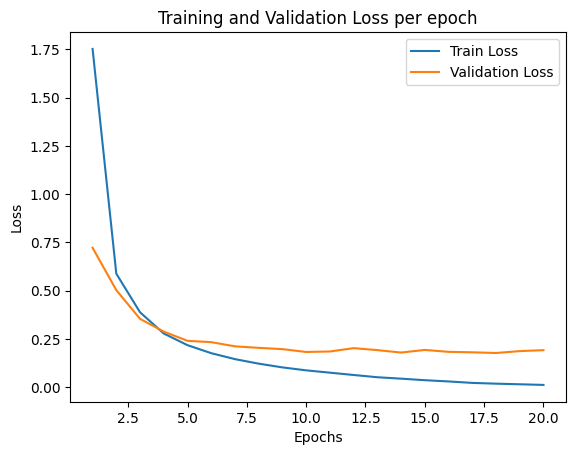

In [48]:
epoch = list(range(1,epoch_length + 1))
plt.plot(epoch, train_loss[:epoch_length], label='Train Loss')
plt.plot(epoch, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss per epoch')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()

Creating the CNN Network now

In [49]:
class CNN(nn.Module):
    def __init__(self, input_size, output_size):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=12, kernel_size=3,padding=0)
        self.conv2 = nn.Conv2d(in_channels=12, out_channels=24, kernel_size=6,padding=0)
        self.conv3 = nn.Conv2d(in_channels=24, out_channels=32, kernel_size=6,padding=0)
        self.fc1 = nn.Linear(32*2*9, 300)
        self.fc2 = nn.Linear(300, output_size)
        
    def forward(self, x, verbose=False):
        x = torch.stack(tuple(x))

        x = self.conv1(x)

        x = F.relu(x)
        x = self.conv2(x)

        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)

        x = self.conv3(x)

        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)

        x = x.view(-1, 32*2*9)

        x = self.fc1(x)

        x = F.relu(x)

        x = self.fc2(x)

        x = F.log_softmax(x, dim=1)

        return x

Training the network

In [51]:
print("Training on ", device)
model_cnn = CNN(input_size, output_size)
model_cnn.to(device)
optimizer = optim.SGD(model_cnn.parameters(), lr=0.001, momentum=0.9)
print('Number of parameters: {}'.format(get_n_params(model_cnn)))

epoch_length = 10
epoch = list(range(epoch_length))
train_loss = list(range(epoch_length))
train_accuracy = list(range(epoch_length))
val_loss = list(range(epoch_length))
val_accuracy = list(range(epoch_length))

for i in range(epoch_length):
    
    print('| Epoch No.: {:.0f}'.format(i + 1))
    print('\n')
    
    train_loss[i], train_accuracy[i], val_loss[i], val_accuracy[i] = train_val(i, model_cnn)

Training on  cuda:0
Number of parameters: 241392
| Epoch No.: 1


| Train_Loss: 0.9934	Train_Accuracy: 0.7491
| Validation_Loss: 0.2283	Validation_Accuracy: 0.9315


| Epoch No.: 2


| Train_Loss: 0.1687	Train_Accuracy: 0.9490
| Validation_Loss: 0.1488	Validation_Accuracy: 0.9538


| Epoch No.: 3


| Train_Loss: 0.1142	Train_Accuracy: 0.9655
| Validation_Loss: 0.1244	Validation_Accuracy: 0.9630


| Epoch No.: 4


| Train_Loss: 0.0897	Train_Accuracy: 0.9724
| Validation_Loss: 0.1120	Validation_Accuracy: 0.9660


| Epoch No.: 5


| Train_Loss: 0.0719	Train_Accuracy: 0.9777
| Validation_Loss: 0.1019	Validation_Accuracy: 0.9696


| Epoch No.: 6


| Train_Loss: 0.0607	Train_Accuracy: 0.9809
| Validation_Loss: 0.0923	Validation_Accuracy: 0.9723


| Epoch No.: 7


| Train_Loss: 0.0513	Train_Accuracy: 0.9838
| Validation_Loss: 0.0834	Validation_Accuracy: 0.9756


| Epoch No.: 8


| Train_Loss: 0.0448	Train_Accuracy: 0.9857
| Validation_Loss: 0.0844	Validation_Accuracy: 0.9760


| Epoch No.: 9


Analysing the performance of the model on the test dataset

In [52]:
test_loss, test_accuracy = test(model_cnn)

| Test_Loss: 0.0602	Test_Accuracy: 0.9817




Therefore, we get an accuracy of 98.17% on the test data after training the model for 10 epochs.

We therefore see that the CNN performs better than the fully connected network on the test dataset even after training it on a lesser number of epochs.

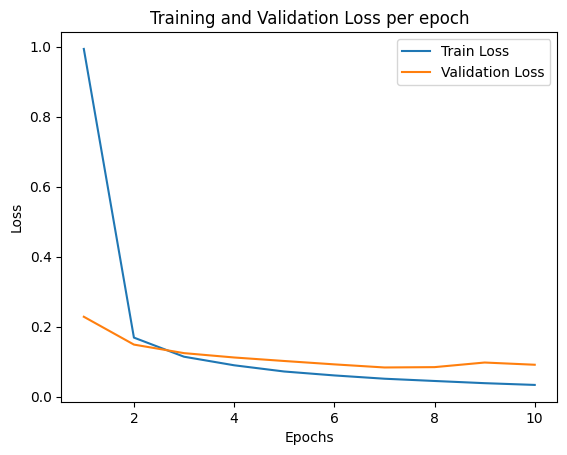

In [53]:
epoch = list(range(1,epoch_length + 1))
plt.plot(epoch, train_loss[:epoch_length], label='Train Loss')
plt.plot(epoch, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss per epoch')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()

Since, CNNs use visual information we see what happens when use scramble inputs

We train the network on the same CNN architecture we defined before

In [54]:
print("Training on ", device)
model_cnn_2 = CNN(input_size, output_size)
model_cnn_2.to(device)
optimizer = optim.SGD(model_cnn_2.parameters(), lr=0.001, momentum=0.9)
print('Number of parameters: {}'.format(get_n_params(model_cnn_2)))

epoch_length = 10
epoch = list(range(epoch_length))
train_loss = list(range(epoch_length))
train_accuracy = list(range(epoch_length))
val_loss = list(range(epoch_length))
val_accuracy = list(range(epoch_length))

for i in range(epoch_length):
    
    print('| Epoch No.: {:.0f}'.format(i + 1))
    print('\n')
    
    train_loss[i], train_accuracy[i], val_loss[i], val_accuracy[i] = scramble_train(i, model_cnn_2, fixed_perm)

Training on  cuda:0
Number of parameters: 241392
| Epoch No.: 1


| Train_Loss: 3.0377	Train_Accuracy: 0.2878
| Validation_Loss: 1.1776	Validation_Accuracy: 0.6591


| Epoch No.: 2


| Train_Loss: 0.8817	Train_Accuracy: 0.7450
| Validation_Loss: 0.7378	Validation_Accuracy: 0.7885


| Epoch No.: 3


| Train_Loss: 0.6054	Train_Accuracy: 0.8225
| Validation_Loss: 0.5992	Validation_Accuracy: 0.8217


| Epoch No.: 4


| Train_Loss: 0.4880	Train_Accuracy: 0.8551
| Validation_Loss: 0.4788	Validation_Accuracy: 0.8589


| Epoch No.: 5


| Train_Loss: 0.4205	Train_Accuracy: 0.8738
| Validation_Loss: 0.4318	Validation_Accuracy: 0.8727


| Epoch No.: 6


| Train_Loss: 0.3752	Train_Accuracy: 0.8866
| Validation_Loss: 0.4404	Validation_Accuracy: 0.8709


| Epoch No.: 7


| Train_Loss: 0.3420	Train_Accuracy: 0.8961
| Validation_Loss: 0.3775	Validation_Accuracy: 0.8891


| Epoch No.: 8


| Train_Loss: 0.3143	Train_Accuracy: 0.9043
| Validation_Loss: 0.3546	Validation_Accuracy: 0.8947


| Epoch No.: 9


Analysing the performance of the model on the test dataset

In [55]:
test_loss, test_accuracy = scramble_test(model_cnn_2, fixed_perm)

| Test_Loss: 0.3397	Test_Accuracy: 0.8957




Therefore, we get an accuracy of 89.57% on the test data after training the model for 10 epochs.

That is, there is a drop of nearly 9% in the accuracy when we scramble the data, since CNNs use visual information

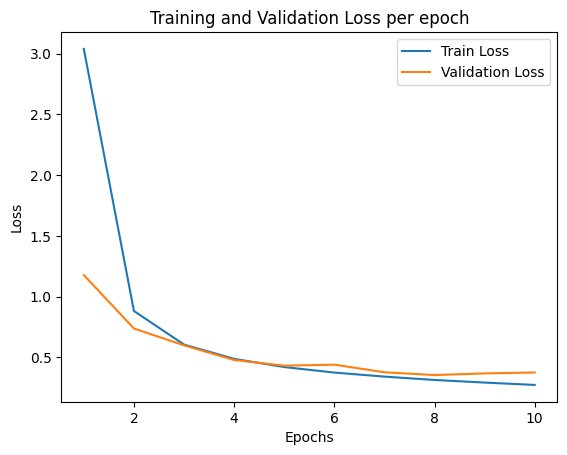

In [56]:
epoch = list(range(1,epoch_length + 1))
plt.plot(epoch, train_loss[:epoch_length], label='Train Loss')
plt.plot(epoch, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss per epoch')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()